{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x500 at 0xFFFF94BA3910>, 'ocr': [{'box': [162.3771596844616, 122.10025860190882, 217.18141746977588, 159.99650489470181], 'cls': 0, 'word': '窦加强'}, {'box': [165.86168630375747, 166.13716746194964, 188.35269200872835, 200.3585893215053], 'cls': 1, 'word': '女'}, {'box': [238.88011088026667, 154.37593979638444, 261.3711165852376, 188.59736165594015], 'cls': 2, 'word': '汉'}, {'box': [169.62497505259702, 205.25134744999744, 208.80441461859186, 234.51112229803132], 'cls': 3, 'word': '1988'}, {'box': [226.41708305654862, 198.90401823366068, 248.21118343766037, 225.36350078036955], 'cls': 4, 'word': '12'}, {'box': [258.86971620166383, 193.67680593785397, 280.66381658277555, 220.13628848456275], 'cls': 5, 'word': '21'}, {'box': [172.97012060712103, 226.08027465055528, 317.07055241797224, 304.3685761136527], 'cls': 6, 'word': '湖南省衡阳市珠晖区'}, {'box': [227.23177169798643, 317.83786419990207, 380.27418940142826, 368.4976578083983], 'cl

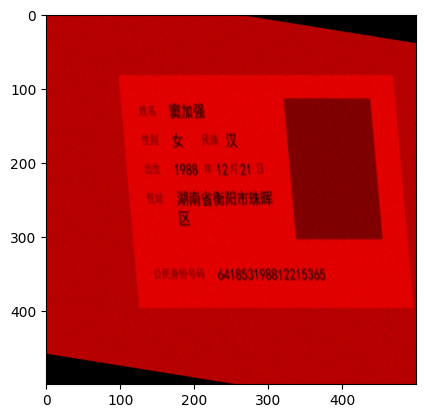

po

宽加强
女 赂汉
1988 年12月214

湖南省衡阳市珠隐
区

 

6041853198812215365

ES




In [ ]:
from datasets import load_dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import pytesseract

ds = load_dataset("lansinuote/ocr_id_card")


testingImage = ds['train'][0]['image']
print(ds['train'][0])
#print(testingImage)
#testingImage.show()
testingImageArray = np.array(testingImage)
#print(testingImageArray.shape)
edgeDetectionArray = cv2.cvtColor(testingImageArray, cv2.COLOR_RGB2GRAY)
#print(edgeDetectionArray.shape)
#plt.imshow(edgeDetectionArray, cmap='gray')
#plt.show()


edges = cv2.Canny(edgeDetectionArray, 100, 200)
#plt.imshow(edges, cmap='gray')
#plt.show()


lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 75, None, 50, 10)
#print(lines)
linesTest = np.zeros(edges.shape) + 250
for i in range(0, len(lines)):
    l = lines[i][0]
    cv2.line(linesTest, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
#plt.imshow(linesTest, cmap='gray')
#plt.show()


# find the least horizontal of horizontal lines of the lines to use for orientation
# this way we know there isn't an issue with the text lines
theta = np.zeros(len(lines))
for i in range(0, len(lines)):
    l = lines[i][0]
    theta[i] = math.atan(abs(l[2] - l[0])/abs(l[3] - l[1]))

# find smallest angle greater than pi/4
#print(theta)
optTheta = 100
optIndex = 0
for k in range(len(theta)):
    if theta[k] > np.pi/4:
        if theta[k] < optTheta:
            optTheta = theta[k]
            optIndex = k
mostHorz = np.float32(lines[optIndex][0])


# find points for the warping
mdpnt = [(mostHorz[0] + mostHorz[2])/2,(mostHorz[1] + mostHorz[3])/2]
#print(mostHorz)
#print(mdpnt)
adjustment = 100
if mdpnt[1] > 250:
    initialPts = np.float32([[mostHorz[0], mostHorz[1]],
                             [mostHorz[2], mostHorz[3]],
                             [mdpnt[0], mdpnt[1] - adjustment]])
    finalPts = np.float32([[mostHorz[0], mdpnt[1]],
                           [mostHorz[2], mdpnt[1]],
                           [mdpnt[0], mdpnt[1] - adjustment]])
else:
    initialPts = np.float32([[mostHorz[0], mostHorz[1]],
                             [mostHorz[2], mostHorz[3]],
                             [mdpnt[0], mdpnt[1] + adjustment]])
    finalPts = np.float32([[mostHorz[0], mdpnt[1]],
                           [mostHorz[2], mdpnt[1]],
                           [mdpnt[0], mdpnt[1] + adjustment]])
#print(initialPts)


# do the warping
M = cv2.getAffineTransform(initialPts, finalPts)
warpedImg = cv2.warpAffine(testingImageArray, M, (testingImageArray.shape[1], testingImageArray.shape[0]))
#plt.imshow(warpedImg)
#plt.show()


# time for the redshift:
redshiftImg = warpedImg
for m in range(warpedImg.shape[0]):
    for n in range(warpedImg.shape[1]):
        redshiftImg[m][n][1] = 0
        redshiftImg[m][n][2] = 0

plt.imshow(redshiftImg)
plt.show()

# OCR I guess
#print(pytesseract.get_languages(config=''))

words = pytesseract.image_to_string(redshiftImg, lang='chi_sim')
print(words)
